# Поиск оптимальных методов использования регуляризаторов при тематическом моделировании средствами BigARTM
___

## 1. Установка библиотек и подгрузка файлов

In [ ]:
!pip install -r requirements.txt

In [1]:
# Если код запускается в Google Colab и данные необходимо подгружать из Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
from tqdm.notebook import tqdm

import zipfile

import numpy as np
import pandas as pd

#import artm

import matplotlib.pyplot as plt

In [ ]:
# Загрузка необходимых файлов
def load_data(zipname):
  z = zipfile.ZipFile(zipname, 'r')
  z.extractall()

def save_data(folder_name):
    pass


load_data("/content/drive/MyDrive/data/ArtmResearch.zip")

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Загрузка и предобработка датасета

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

In [ ]:
texts_to_titles = pd.read_csv('medium_articles.csv', usecols=[0, 1], nrows=4000)
texts = texts_to_titles['text']
texts

0       Photo by Josh Riemer on Unsplash\n\nMerry Chri...
1       Your Brain On Coronavirus\n\nA guide to the cu...
2       Mind Your Nose\n\nHow smell training can chang...
3       Passionate about the synergy between science a...
4       You’ve heard of him, haven’t you? Phineas Gage...
                              ...                        
3995    The One Year Plan For Cracking Coding Intervie...
3996    “Machine learning will automate jobs that most...
3997    Product Seven\n\nThe seven steps necessary to ...
3998    What’s new in iOS 14?\n\nThe main changes that...
3999    Why Small Data is a Big Deal\n\nHere’s how sma...
Name: text, Length: 4000, dtype: object

In [ ]:
import scipy as sp
# Векторизация текстов
def vectorize_texts(tokenized_texts, word2id):
    # считаем количество употреблений каждого слова в каждом документе
    result = sp.sparse.dok_matrix((len(word2id), len(tokenized_texts)), dtype='int32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[word2id[token], text_i] += 1

    # получаем вектора относительных частот слова в документе
    # result = result.tocsc()
    # result = result.multiply(1 / result.sum(axis=0))

    return result.tocoo()

### 1.1. Создание файлов формата UCI для одиночных слов

In [ ]:
# Построение словаря
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import collections

def build_vocabulary4words(tokenized_texts, max_size=1000000, max_doc_freq=1, min_count=2, stop_w=True):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    lemmatizer = WordNetLemmatizer()

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set([lemmatizer.lemmatize(word.lower()) for word in txt])
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # убрать стоп слова
    if stop_w:
        stop_words = set(stopwords.words('english'))
        word_counts = {word: cnt for word, cnt in word_counts.items()
                       if word not in stop_words}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq

In [ ]:
%%time
# Токенизация
from nltk.tokenize import RegexpTokenizer

def tokenize_texts(texts, min_length=3):
    pattern = '[A-Za-z]{{{}}}[A-Za-z]+'.format(min_length)
    tokenizer = RegexpTokenizer(pattern)
    tokenized_texts = [tokenizer.tokenize(text) for text in texts]
    return [token for token in tokenized_texts]

tokenized_texts = tokenize_texts(texts)

CPU times: user 1.58 s, sys: 196 ms, total: 1.78 s
Wall time: 1.85 s


In [ ]:
%%time
# Построение словаря
vocabulary, word2freq = build_vocabulary4words(tokenized_texts, max_doc_freq=0.6, min_count=5)

CPU times: user 13.7 s, sys: 34.3 ms, total: 13.7 s
Wall time: 14 s


In [ ]:
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 14776
[('need', 0), ('work', 1), ('first', 2), ('even', 3), ('people', 4), ('thing', 5), ('take', 6), ('would', 7), ('want', 8), ('know', 9)]


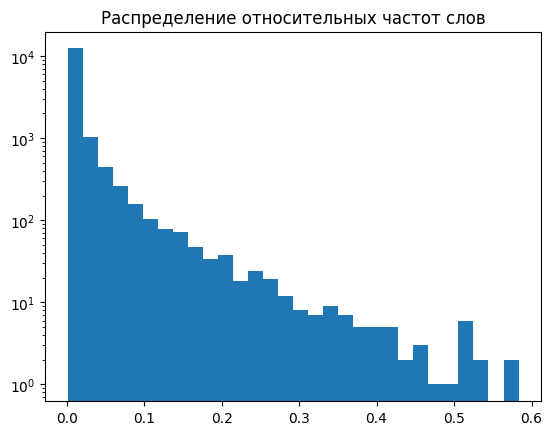

In [ ]:
import matplotlib.pyplot as plt

plt.hist(word2freq, bins=30)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [ ]:
%%time
# Векторизация текстов
vectors = vectorize_texts(tokenized_texts, vocabulary)

W, D = vectors.shape
print('Размерность матрицы', (W, D))
NNZ = vectors.nnz
print('Количество ненулевых элементов', NNZ)
print('Процент заполненности матрицы {:.2f}%'.format(vectors.nnz * 100 / (vectors.shape[0] * vectors.shape[1])))

Размерность матрицы (14776, 4000)
Количество ненулевых элементов 791755
Процент заполненности матрицы 1.34%
CPU times: user 43.5 s, sys: 297 ms, total: 43.8 s
Wall time: 47.5 s


In [ ]:
with open('UCI/docword.words.txt', 'w') as file:
    file.write('{}\n{}\n{}\n'.format(D, W, NNZ))
    for w, d, value in zip(vectors.row, vectors.col, vectors.data):
        file.write('{} {} {}\n'.format(d + 1, w + 1,  value))

In [ ]:
with open('UCI/vocab.words.txt', 'w') as file:
    for w in vocabulary:
        file.write('{}\n'.format(w))

## 3. Знакомство с BigARTM: Построение тем без оптимизации гиперпараметров

### 3.1 Построение тем без дополнительных модальностей

In [ ]:
COLLECTION_NAME = 'words'

In [ ]:
%%time
batch_vectorizer = artm.BatchVectorizer(data_path='UCI',
                                        data_format='bow_uci',
                                        collection_name=COLLECTION_NAME,
                                        target_folder='{}_batches'.format(COLLECTION_NAME))

In [ ]:
# Если уже создан словарь
dictionary = artm.Dictionary()
dictionary.load_text(dictionary_path='{}_batches/dictionary.txt'.format(COLLECTION_NAME))

In [ ]:
# Если нужно создать новый
dictionary = artm.Dictionary()
dictionary.gather(data_path='{}_batches'.format(COLLECTION_NAME),
                  vocab_file_path='UCI\\vocab.{}.txt'.format(COLLECTION_NAME))



In [ ]:
dictionary.save_text(dictionary_path='{}_batches/dictionary.txt'.format(COLLECTION_NAME))

Создание модели

In [ ]:
THEMES_AMOUNT = 50

model = artm.ARTM(num_topics=THEMES_AMOUNT, dictionary=dictionary)
model.cache_theta = True

In [ ]:
# В ходе исследования простое решение строится без регуляризаторов
# model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
# model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer', tau=-1.5))
# model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e5))

In [ ]:
model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                      dictionary=dictionary))

NUM_TOCKENS = 10
model.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                     num_tokens=NUM_TOCKENS))

model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

In [ ]:
%%time
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=24)

CPU times: user 1min 15s, sys: 684 ms, total: 1min 15s
Wall time: 1min 12s


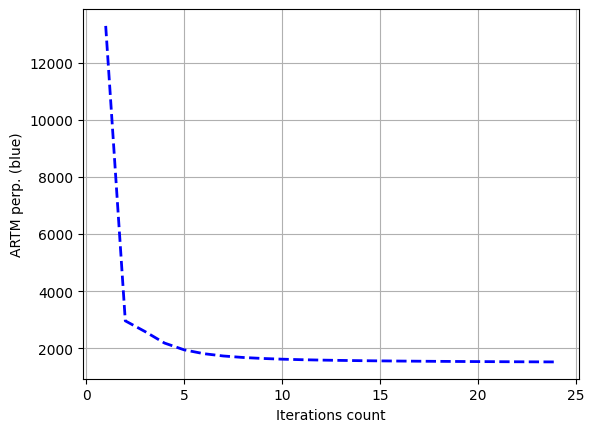

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, model.num_phi_updates + 1),
             model.score_tracker['PerplexityScore'].value, 'b--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp. (blue)')
plt.grid(True)
plt.show()

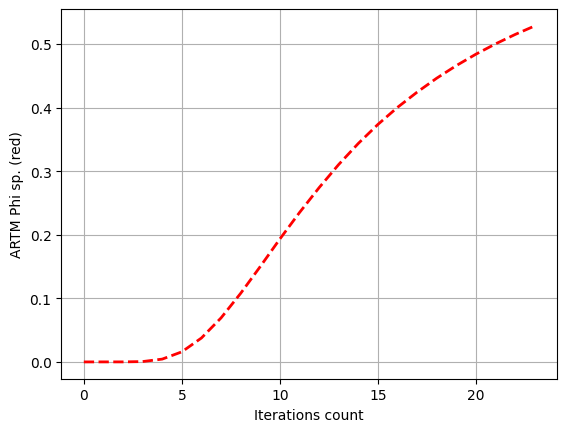

In [ ]:
plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

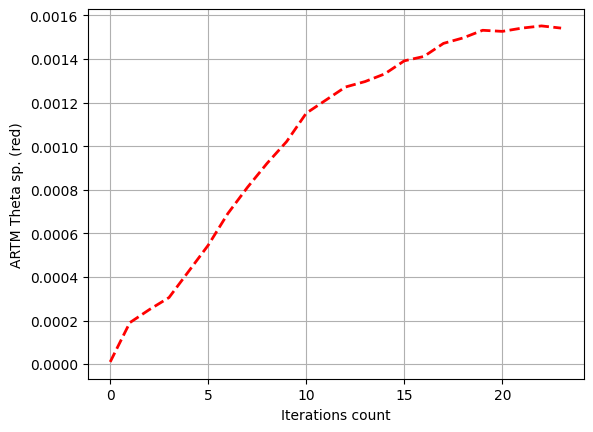

In [ ]:
plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [ ]:
# Если модель начала деградировать, но не хочется создавать новую
# model.initialize(dictionary=dictionary)

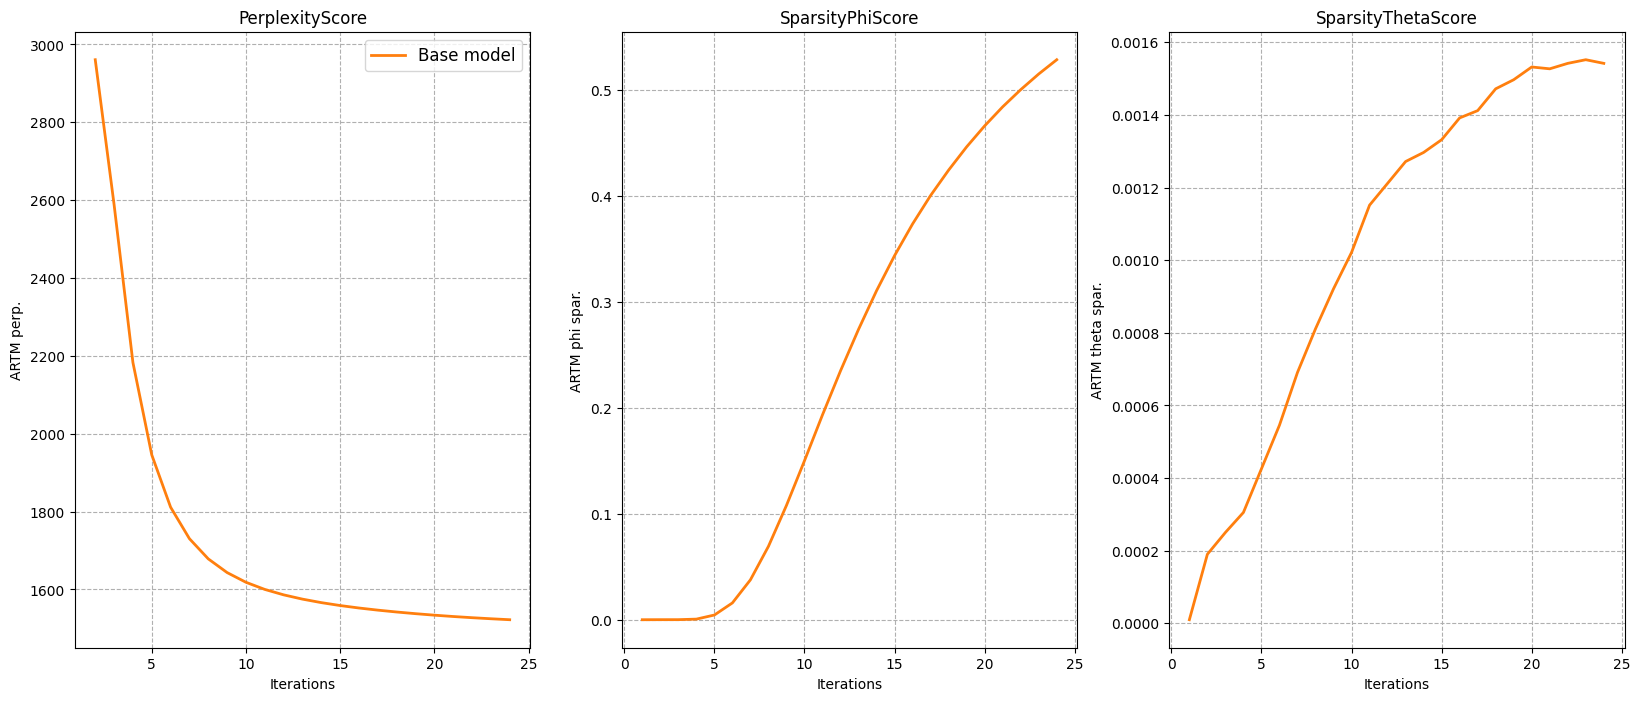

In [ ]:
diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))
diagram.add_scores(model, f"Base model", c="tab:orange", start=1)
diagram.show()

In [ ]:
for topic_name in model.topic_names:
    try:
        print(topic_name + ':', model.score_tracker['TopTokensScore'].last_tokens[topic_name])
    except KeyError:
        pass

topic_1: ['writing', 'write', 'story', 'writer', 'work', 'read', 'want', 'creative', 'people', 'first']
topic_3: ['work', 'team', 'people', 'working', 'help', 'need', 'also', 'company', 'business', 'learn']
topic_5: ['color', 'text', 'screen', 'style', 'component', 'layout', 'font', 'background', 'size', 'black']
topic_9: ['energy', 'water', 'food', 'climate', 'plastic', 'change', 'carbon', 'temperature', 'waste', 'plant']
topic_10: ['book', 'read', 'music', 'reading', 'movie', 'novel', 'author', 'film', 'fiction', 'poetry']
topic_11: ['human', 'intelligence', 'science', 'technology', 'driving', 'artificial', 'computer', 'quantum', 'brain', 'consciousness']
topic_12: ['people', 'public', 'pandemic', 'health', 'government', 'social', 'country', 'many', 'virus', 'political']
topic_14: ['life', 'home', 'back', 'said', 'never', 'family', 'felt', 'love', 'could', 'would']
topic_15: ['business', 'market', 'company', 'money', 'customer', 'product', 'price', 'value', 'financial', 'cost']
topic

## 4. Исследование качества модели при различных методиках включения регуляризаторов

## 4.1 Загрузка предобработанных данных в память

In [ ]:
%%time
COLLECTION_NAME = 'words'

batch_vectorizer = artm.BatchVectorizer(data_path='UCI',
                                        data_format='bow_uci',
                                        collection_name=COLLECTION_NAME,
                                        target_folder='{}_batches'.format(COLLECTION_NAME))

CPU times: user 2.33 s, sys: 193 ms, total: 2.52 s
Wall time: 9.33 s


In [ ]:
# Загрузка созданного словаря
dictionary = artm.Dictionary()
dictionary.load_text(dictionary_path='{}_batches/dictionary.txt'.format(COLLECTION_NAME))

## 4.2 Исследование влияния отдельных регуляризаторов на выбранные метрики

В данном параграфе будут выполнены за работой регуляризаторов из списка в отдельности, при их включении с самого начала обучения модели.
Рассмотрим следующие регуляризатотры, реализованные в проекте BigARTM:

1.  Декоррелирование распределения термов в темах
2.  Разреживание распределений тем в документах
3.  Разреживание распределений термов в темах
4.  Сглаживание распределений тем в документах
5.  Сглаживание распределений термов в темах
6.  Отбор тем

Для оценивания работы регуляризаторов были выбраны следующие метрики:

1.  Перплексия
2.  Разреженность матрицы Φ
3.  Разреженность матрицы Θ





In [ ]:
def create_artm_model():
    THEMES_AMOUNT = 50
    NUM_TOCKENS = 12

    model = artm.ARTM(num_topics=THEMES_AMOUNT, dictionary=dictionary)

    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                          dictionary=dictionary))

    model.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                         num_tokens=NUM_TOCKENS))

    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    return model

In [ ]:
class Diagram:
    def __init__(self, nrows, ncols, figsize):
        fig, axs = plt.subplots(nrows=nrows , ncols=ncols, figsize=figsize)
        self.fig = fig
        self.axs = axs
        self.scores = list()

    def add_scores(self, model, label, c='r', start=0):
        self.axs[0].plot(range(1, model.num_phi_updates + 1)[start:],
         model.score_tracker['PerplexityScore'].value[start:], color=c, linewidth=2, label=label)
        self.axs[1].plot(range(1, model.num_phi_updates + 1),
            model.score_tracker['SparsityPhiScore'].value, color=c, linewidth=2, label=label)
        self.axs[2].plot(range(1, model.num_phi_updates + 1),
            model.score_tracker['SparsityThetaScore'].value, color=c, linewidth=2, label=label)

        self.scores.append(model.score_tracker['PerplexityScore'].value[-1])

    def show(self):
        self.axs[0].set_xlabel('Iterations')
        self.axs[0].set_ylabel('ARTM perp.')
        self.axs[0].grid(linestyle='--')
        self.axs[0].legend(loc="upper right", prop = { "size": 12 })
        self.axs[0].set_title('PerplexityScore')

        self.axs[1].set_xlabel('Iterations')
        self.axs[1].set_ylabel('ARTM phi spar.')
        self.axs[1].grid(linestyle='--')
        self.axs[1].set_title('SparsityPhiScore')

        self.axs[2].set_xlabel('Iterations')
        self.axs[2].set_ylabel('ARTM theta spar.')
        self.axs[2].grid(linestyle='--')
        self.axs[2].set_title('SparsityThetaScore')
        plt.show()

    def best_tau(self, tau_vals):
        return tau_vals[np.argmax(-np.array(self.scores))]

In [ ]:
def test_tau_vals(regularizer, name, tau_vals, colors, epoch=8):
    diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))

    for i, tau in tqdm(enumerate(tau_vals), total=len(tau_vals)):
        model = create_artm_model()

        model.regularizers.add(regularizer(name=name, tau=tau))
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)
        diagram.add_scores(model, f"tau={tau}", c=colors[i], start=1)

    best_param = diagram.best_tau(tau_vals)
    print("Best parametr value: {}".format(best_param))

    diagram.show()
    return best_param

Необходимо заметить, что в ноутбуке приведены конечные результаты, при проведении экспериментов было протестировано куда большее количество гиперпараметров. В итоге были выбраны приведенные грубые сетки и количество эпох обучения. Большое количество эпох (больше 10) значительно улучшало метрики, что приводило к подобию переобучения модели и не позволяло получить значительных положительных результытов в дальнейшем. В связи с этим было выбрано число 6 - 8 эпох для обучения.

### 4.2.1 Декоррелирование распределения термов в темах



  0%|          | 0/4 [00:00<?, ?it/s]

Best parametr value: 500000


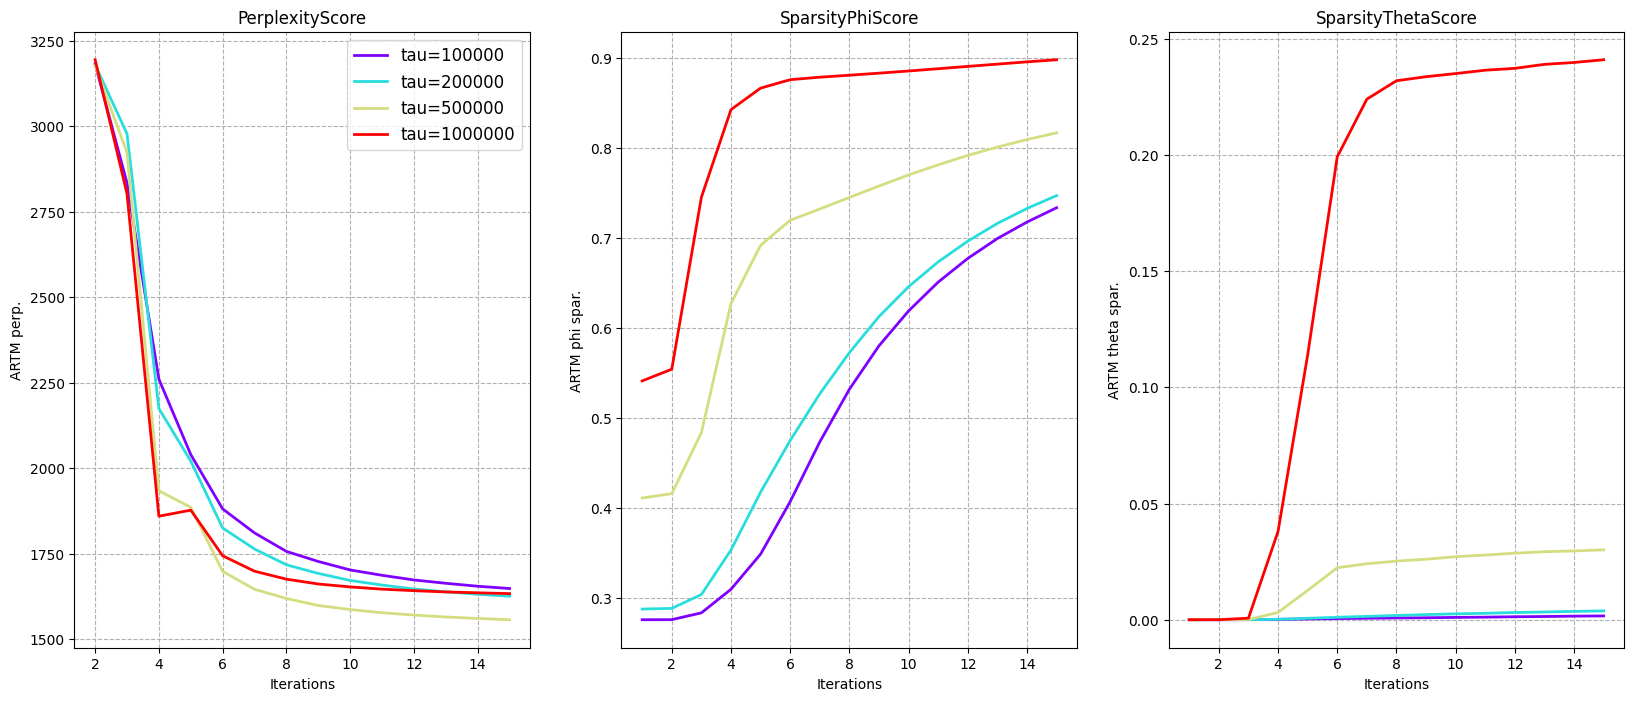

CPU times: user 3min 57s, sys: 4.28 s, total: 4min 1s
Wall time: 3min 30s


In [ ]:
%%time
tau_vals = np.array([1e5, 2e5, 5e5, 1e6], dtype=np.int32)
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

BEST_DECOR = test_tau_vals(artm.DecorrelatorPhiRegularizer, 'DecorrelatorPhi', tau_vals, colors, 15)

Видно улучшение всех трех метрик, хотя и не столь идеальное, как ожидалось. Тем не менее полученный результат можно объяснить. Так как регуляризатор для декоррелирования распределения термов в темах представляет собой скалярное произведения строк матрицы Φ, то при слишком больших значениях параметра регуляризатор теряет свой смысл и начинает занулять элементы матрицы Φ (Для нулевой Φ значение регуляризатора действительно максимально и равно 0). Например, формулу регуляризатора:
\begin{align}
        R(\Phi) &= - \tau \sum_{s, t \in T} \sum_{w \in W} \phi_{wt} \phi_{ws}
\end{align}

Можно рассматривать как сумму скалярных произведений строк матрицы $\Phi$, а оно минимально если в каждой теме по 1 слову. Данный эффект нас не удовлетворяет

### 4.2.2 Разреживание распределений термов в темах

  0%|          | 0/4 [00:00<?, ?it/s]

Best parametr value: -0.25


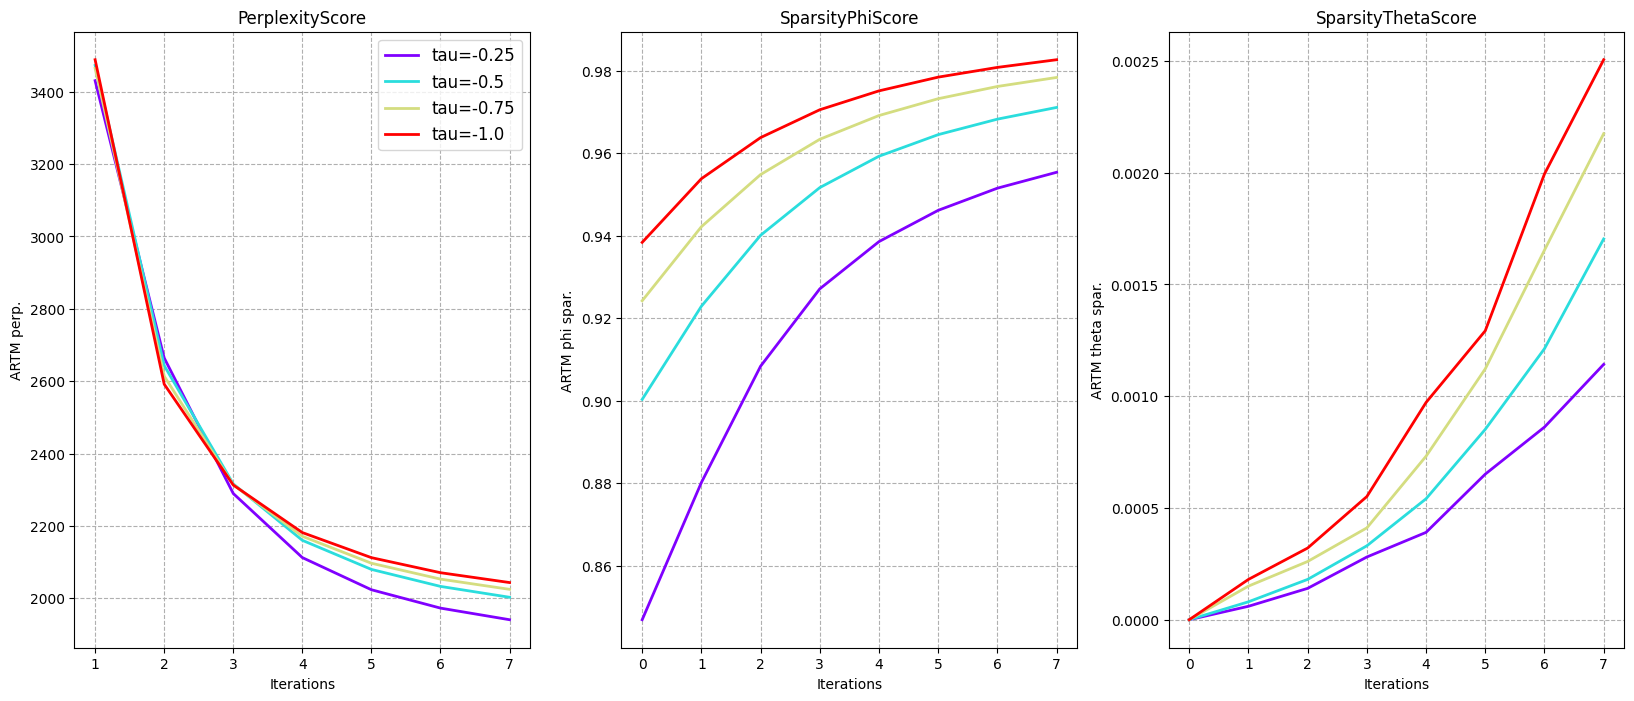

CPU times: user 1min 9s, sys: 504 ms, total: 1min 9s
Wall time: 59.1 s


-0.25

In [ ]:
%%time
tau_vals = np.arange(1, 5) / 4
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_tau_vals(artm.SmoothSparsePhiRegularizer, 'SparsePhi', -tau_vals, colors)

Видна четкая корреляция между снижением перплексии и повышением разреженности

### 4.2.3 Разреживание распределений тем в документах

  0%|          | 0/4 [00:00<?, ?it/s]

Best parametr value: -1.0


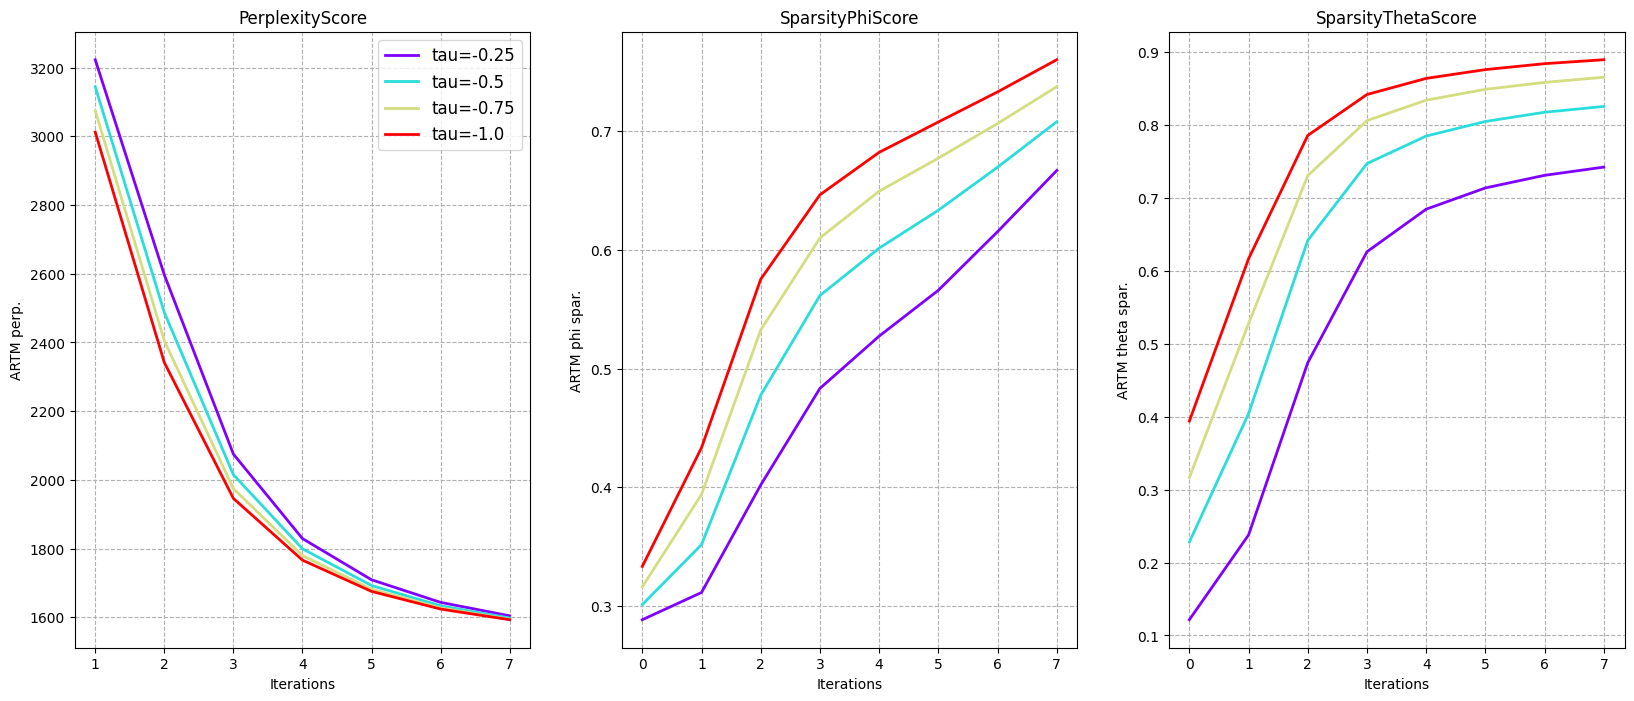

CPU times: user 1min 12s, sys: 724 ms, total: 1min 13s
Wall time: 1min


-1.0

In [ ]:
%%time
tau_vals = np.arange(1, 5) / 4
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_tau_vals(artm.SmoothSparseThetaRegularizer, 'SparseTeta', -tau_vals, colors)

Нет явного перимущества в перплексии, но нет и ее ухудшения при одновременном улучшении разреженности

### 4.2.4 Сглаживание распределений термов в темах

  0%|          | 0/4 [00:00<?, ?it/s]

Best parametr value: 0.5


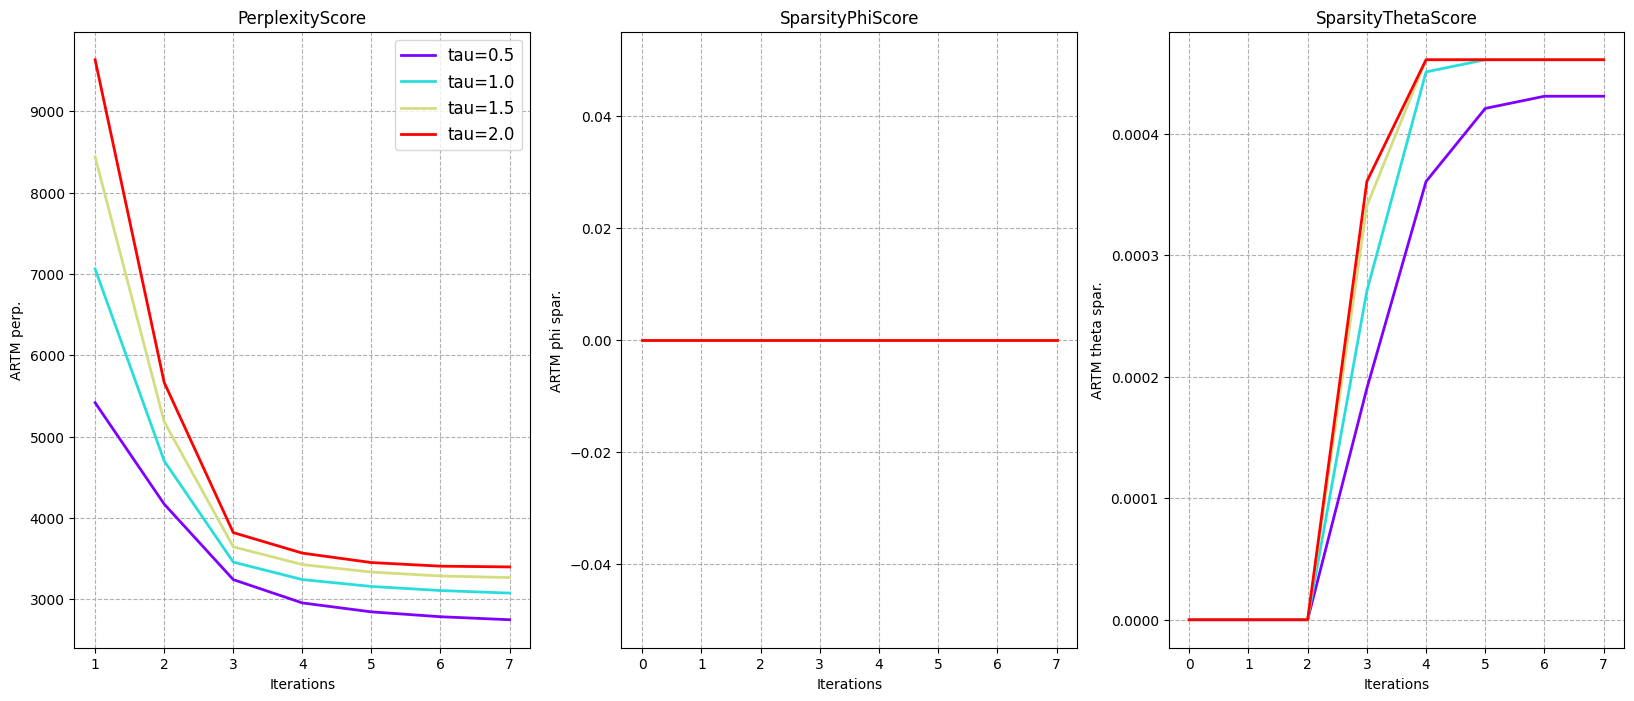

CPU times: user 1min 16s, sys: 1.43 s, total: 1min 18s
Wall time: 1min 23s


0.5

In [ ]:
%%time
tau_vals = np.arange(1, 5) / 2
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_tau_vals(artm.SmoothSparsePhiRegularizer, 'SmoothPhi', tau_vals, colors)

Видна четкая корреляция между снижением перплексии и повышением разреженности

### 4.2.5 Сглаживание распределений тем в документах

  0%|          | 0/4 [00:00<?, ?it/s]

Best parametr value: 0.5


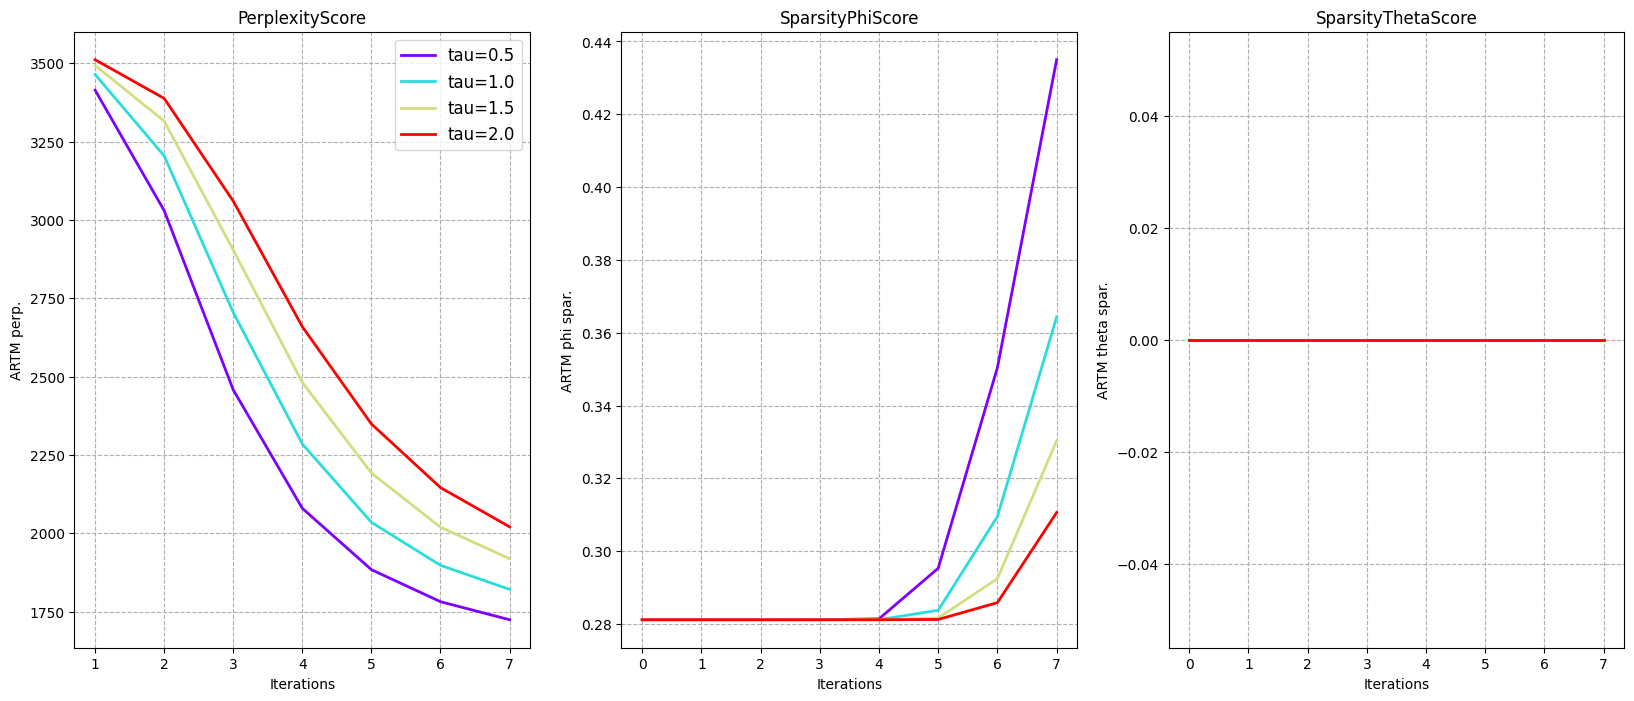

CPU times: user 1min 13s, sys: 1 s, total: 1min 14s
Wall time: 59.3 s


0.5

In [ ]:
%%time
tau_vals = np.arange(1, 5) / 2
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_tau_vals(artm.SmoothSparseThetaRegularizer, 'SmoothTeta', tau_vals, colors)

### 4.2.6 Отбор тем

  0%|          | 0/4 [00:00<?, ?it/s]

Best parametr value: 0.2


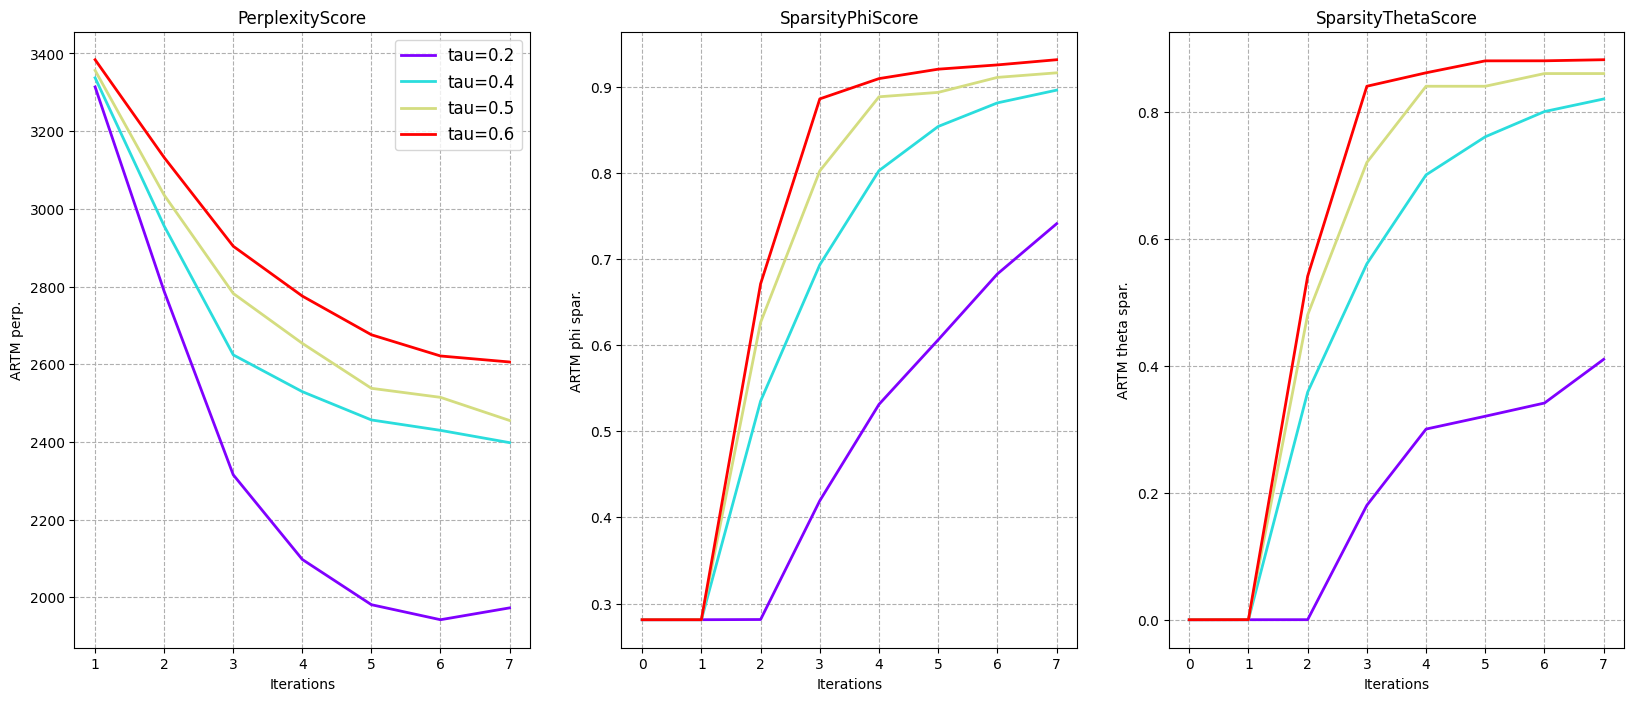

CPU times: user 1min 10s, sys: 1.12 s, total: 1min 11s
Wall time: 1min 2s


0.2

In [ ]:
%%time
tau_vals = np.array([20, 40, 50, 60]) / 100
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_tau_vals(artm.TopicSelectionThetaRegularizer, 'TopicSelector', tau_vals, colors)

Видна четкая корреляция между снижением перплексии и повышением разреженности

По результатам экспериментов можно сделать вывод, что на первых эпохах построения тем лучше всего себя проявляет регуляризатор для декоррелирования распределения термов в темах. Он дает улучшение всех трех рассматриваемых метрик.

## 4.3 Построение оптимального порядка

Далее возьмем оптимальное значение параметра для декоррелятора распределения термов и выясним, изменится ли поведение уже рассмотренных регуляризаторов при их включении после некоторого числа итераций со включенным начальным регуляризатором. Проведем эксперименты как оставляя, так и выключая декоррелятор.

In [ ]:
def test_with2reg(regularizer, name, tau_vals, colors, epoch=8, show_themes=0):
    diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))


    for (tau, c) in tqdm(zip(tau_vals, colors), total=len(tau_vals)):
        model = create_artm_model()

        model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=BEST_DECOR))
        model.regularizers.add(regularizer(name=name, tau=0))
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

        model.regularizers[name].tau = tau
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)
        diagram.add_scores(model, f"tau={tau}", c, epoch)

    best_tau = diagram.best_tau(tau_vals)
    print("Best tau value: {}".format(best_tau))

    diagram.show()
    if show_themes:
        for topic_name in model.topic_names:
            try:
                print(topic_name + ':', model.score_tracker['TopTokensScore'].last_tokens[topic_name])
            except KeyError:
                pass
    return best_tau

### 4.3.1 Разреживание распределений термов в темах

In [ ]:
%%time
tau_vals = np.arange(1, 5) / 2
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_with2reg(artm.SmoothSparsePhiRegularizer, 'SparsePhi', -tau_vals, colors, 6)

Видна четкая корреляция между снижением перплексии и повышением разреженности

### 4.3.2 Разреживание распределений тем в документах

  0%|          | 0/4 [00:00<?, ?it/s]

Best tau value: -0.25


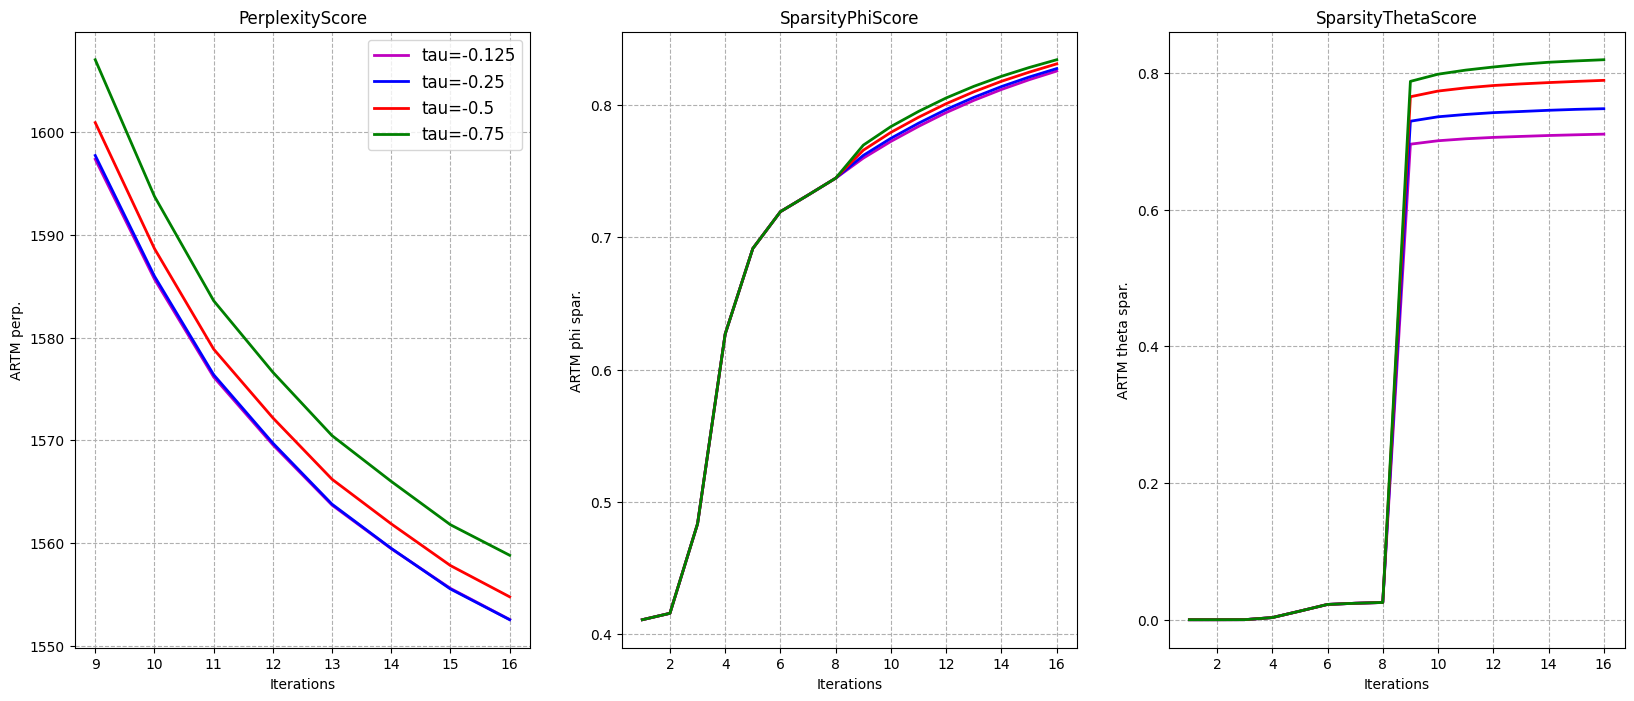

CPU times: user 4min 6s, sys: 3.92 s, total: 4min 10s
Wall time: 3min 15s


In [ ]:
%%time
tau_vals = np.array([0.125, 0.25, 0.5, 0.75])
colors = ('m', 'b', 'r', 'g')

BEST_THETA_SPARSE = test_with2reg(artm.SmoothSparseThetaRegularizer, 'SparseTheta', -tau_vals, colors, 8)

Заметно, что при значении параметра = -0.5 получено улучшение всех параметров (кроме разреженности распределений тем в документах)

### 4.3.3 Сглаживание распределений термов в темах

  0%|          | 0/5 [00:00<?, ?it/s]

Best tau value: 0.0


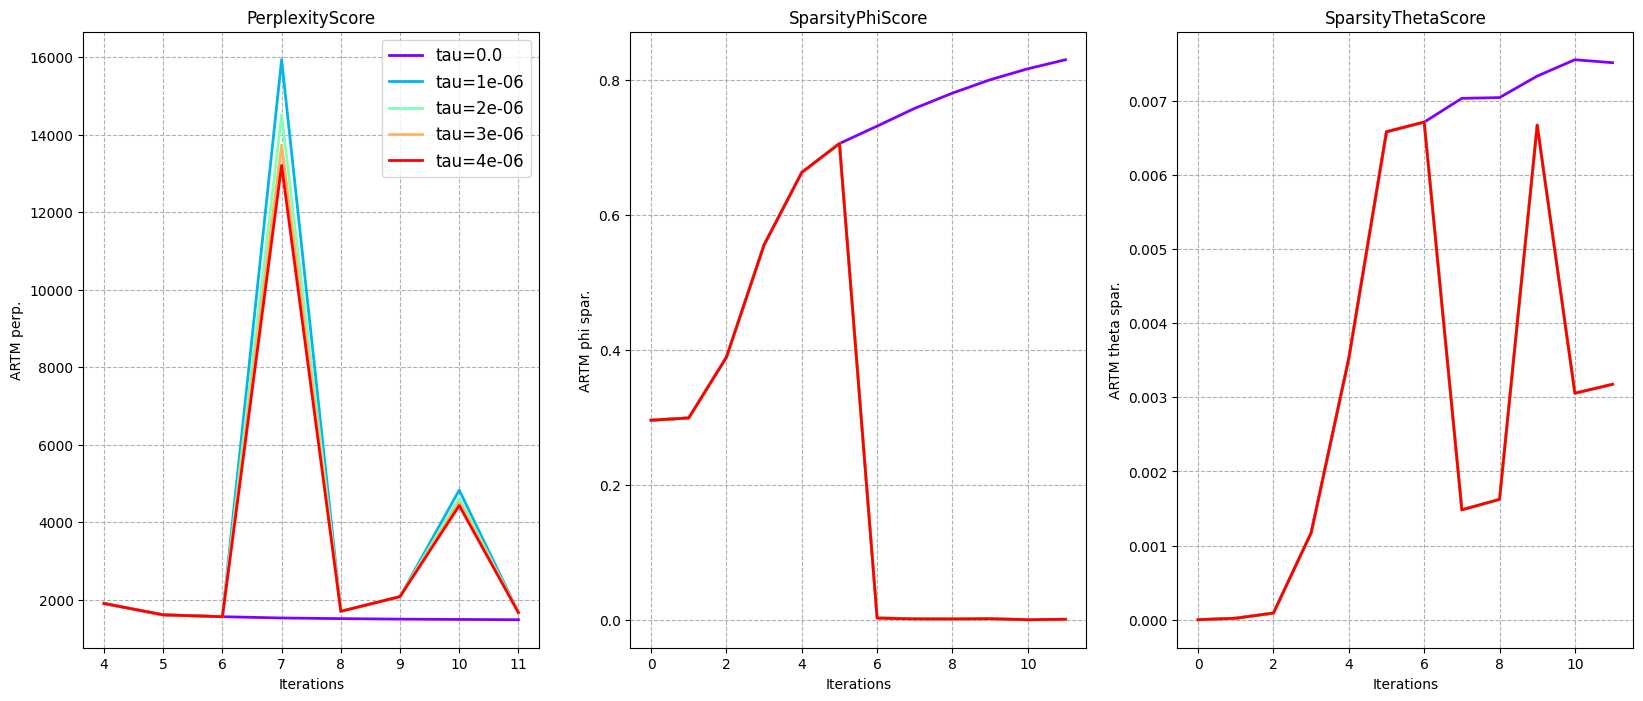

CPU times: user 2min 36s, sys: 1.92 s, total: 2min 38s
Wall time: 2min 12s


In [ ]:
%%time
tau_vals = np.arange(0, 5) / 4
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_with2reg(artm.SmoothSparsePhiRegularizer, 'SmoothPhi', tau_vals, colors, 6)

### 4.3.4 Сглаживание распределений тем в документах


  0%|          | 0/4 [00:00<?, ?it/s]

Best tau value: 0.25


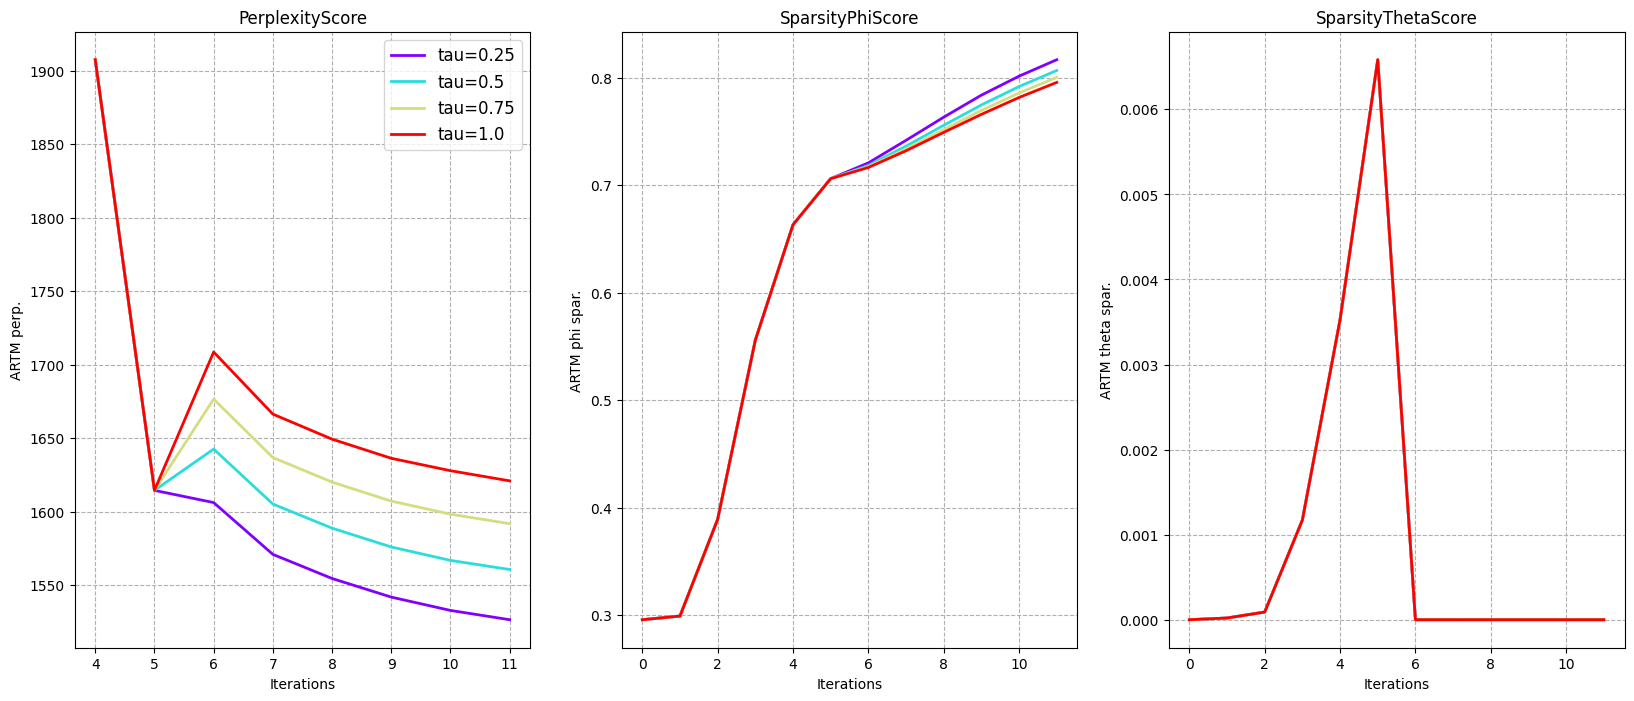

CPU times: user 2min 2s, sys: 1.55 s, total: 2min 3s
Wall time: 1min 41s


In [ ]:
%%time
tau_vals = np.arange(1, 5) / 4
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_with2reg(artm.SmoothSparseThetaRegularizer, 'SmoothTeta', tau_vals, colors, 6)

Неплохой результат в первых двух метриках, но излишнее воздействие на разреженность распределений тем в документах

### 4.3.5 Отбор тем

  0%|          | 0/4 [00:00<?, ?it/s]

Best tau value: 0.2


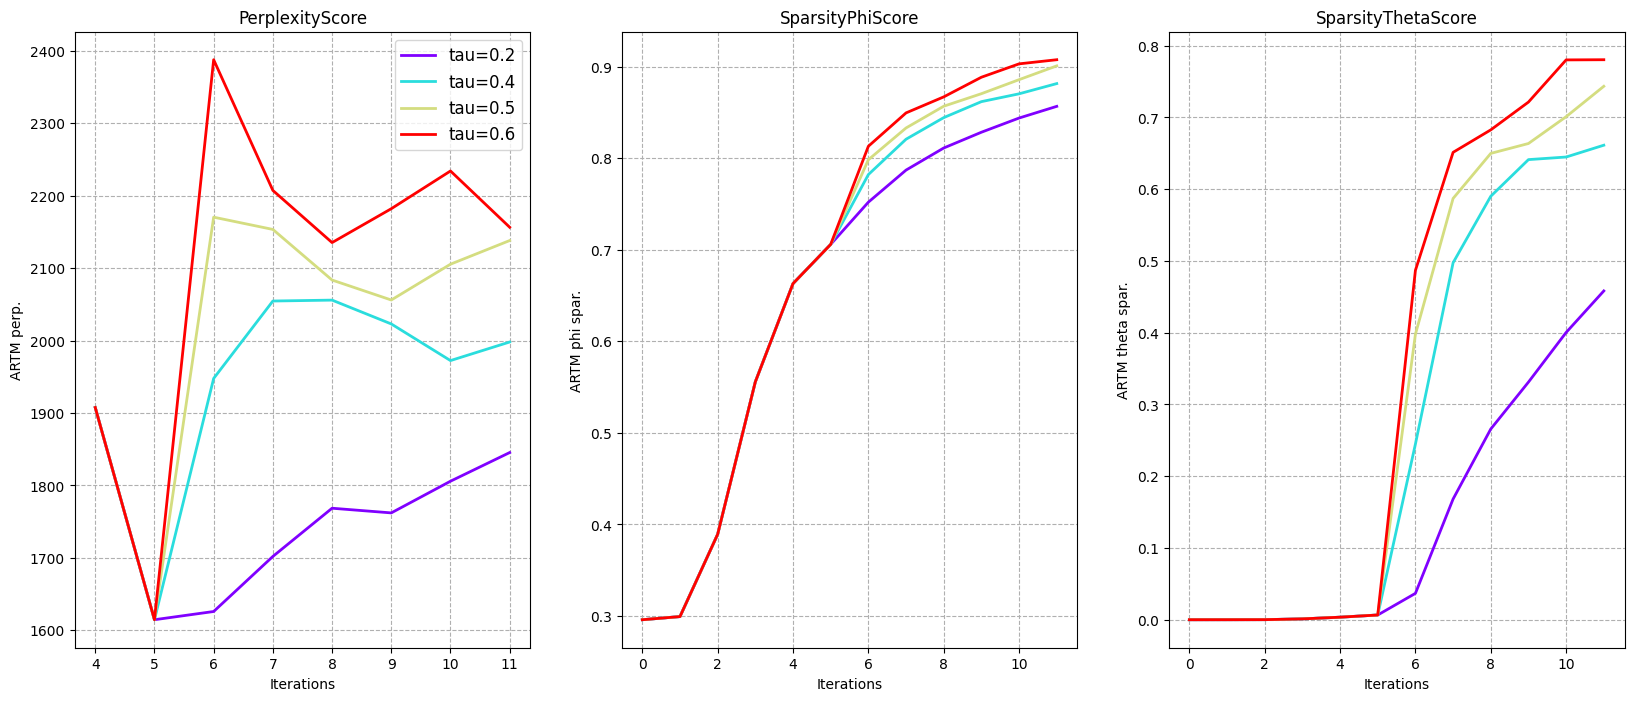

CPU times: user 1min 57s, sys: 1.49 s, total: 1min 59s
Wall time: 1min 38s


In [ ]:
%%time
tau_vals = np.array([20, 40, 50, 60]) / 100
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_with2reg(artm.TopicSelectionThetaRegularizer, 'TopicSelector', tau_vals, colors, 6)

### 4.3.6 А нужно ли оставлять включенным регуляризатор для декореляции?

До этого начальный регуляризатор оставался включенным во время всего обучения. Проверим экспирементально, необходимо ли это.

In [ ]:
def test_with2reg_v2(regularizer, name, tau_vals, colors, epoch=7):
    diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))


    for (tau, c) in tqdm(zip(tau_vals, colors), total=len(tau_vals)):
        model = create_artm_model()

        model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=BEST_DECOR))
        model.regularizers.add(regularizer(name=name, tau=0))

        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

        model.regularizers['DecorPhi'].tau = 0
        model.regularizers[name].tau = tau

        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)
        diagram.add_scores(model, tau, c, epoch)

    best_tau = diagram.best_tau(tau_vals)
    print("Best tau value: {}".format(best_tau))

    diagram.show()

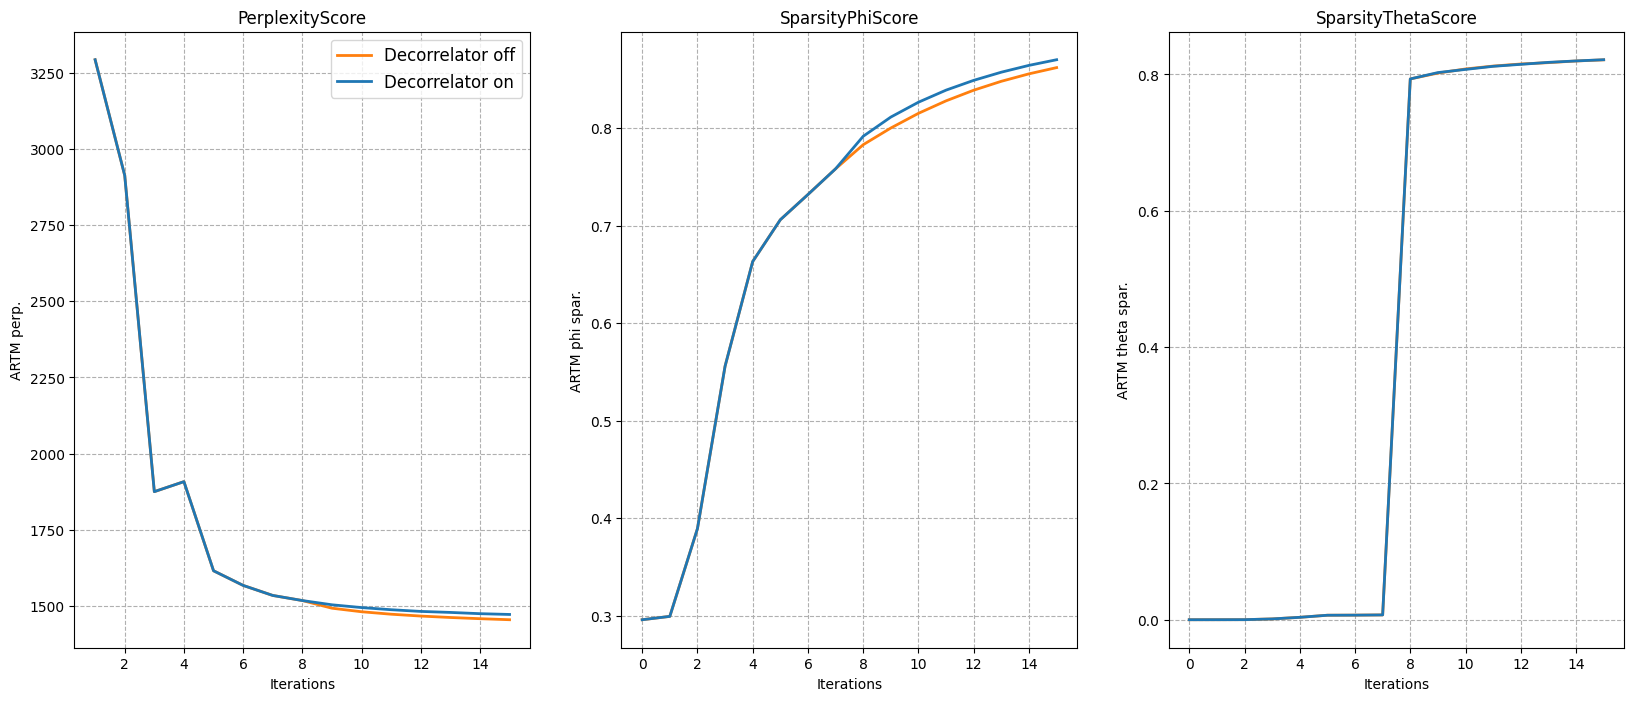

CPU times: user 1min 16s, sys: 782 ms, total: 1min 17s
Wall time: 1min 4s


In [ ]:
%%time
EPOCH = 8

diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))

model = create_artm_model()
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=BEST_DECOR))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=EPOCH)
model.regularizers['DecorPhi'].tau = 0
model.regularizers['SparseTheta'].tau = BEST_THETA_SPARSE
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=EPOCH)
diagram.add_scores(model, 'Decorrelator off', 'tab:orange', 1)

model = create_artm_model()
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=BEST_DECOR))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=EPOCH)
model.regularizers['SparseTheta'].tau = BEST_THETA_SPARSE
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=EPOCH)
diagram.add_scores(model, 'Decorrelator on', 'tab:blue', 1)

diagram.show()

### 4.3.7 А нужно ли включать поочередно?

In [ ]:
def test_with2reg_v3(regularizer, name, tau_vals, colors, epoch=8):
    diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))


    for (tau, c) in tqdm(zip(tau_vals, colors), total=len(tau_vals)):
        model = create_artm_model()

        model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=BEST_DECOR))
        model.regularizers.add(regularizer(name=name, tau=tau))
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=2 * epoch)

        diagram.add_scores(model, tau, c, 4)

    best_tau = diagram.best_tau(tau_vals)
    print("Best tau value: {}".format(best_tau))

    diagram.show()

Подберем оптимальный параметр в случае одновременного вклячения регуляризаторов

  0%|          | 0/4 [00:00<?, ?it/s]

Best tau value: -0.5


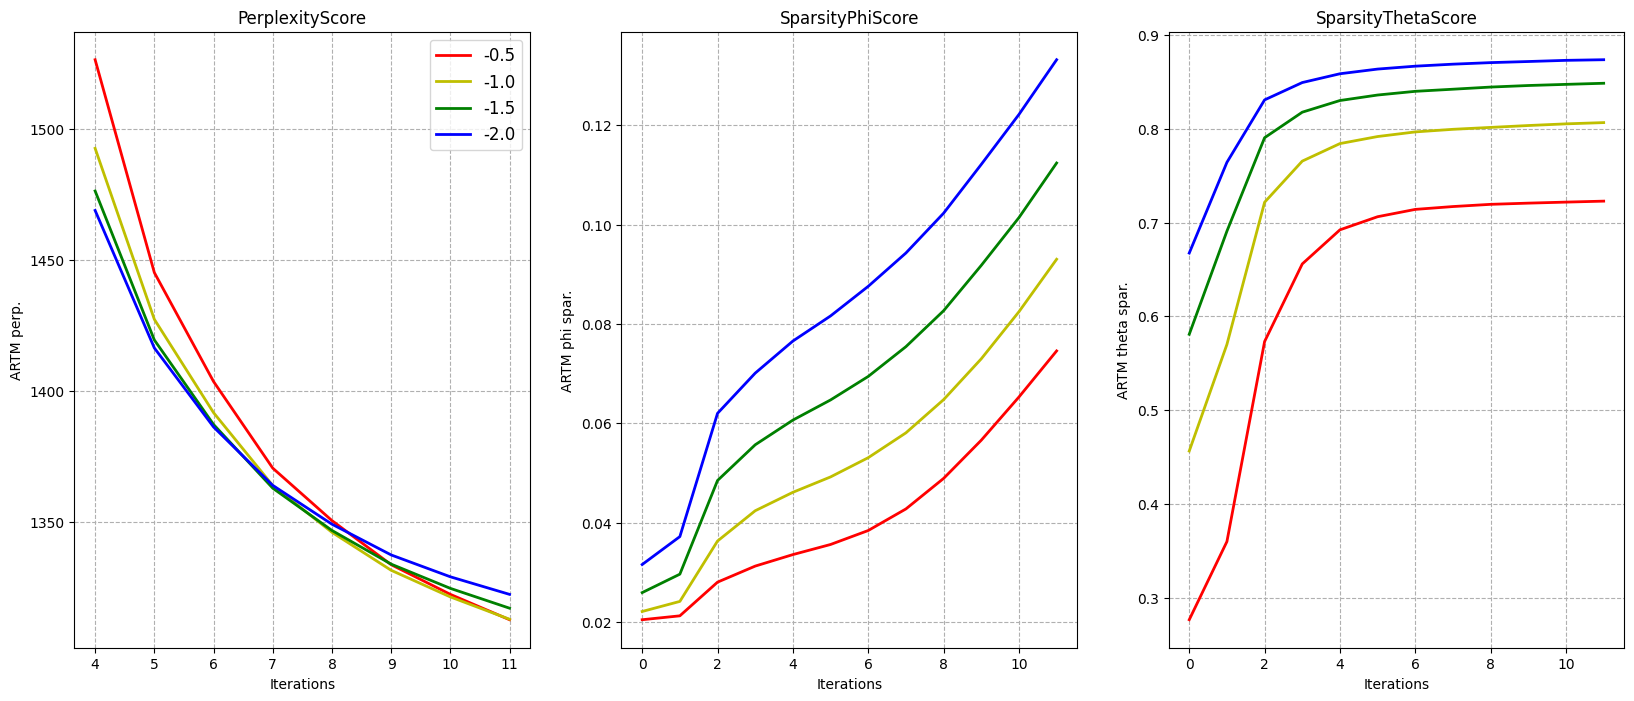

CPU times: user 4min 47s, sys: 3.88 s, total: 4min 51s
Wall time: 3min 58s


In [ ]:
%%time
tau_vals = np.arange(1, 5) / 2
colors = ("r", "y", "g", "b")

test_with2reg_v3(artm.SmoothSparseThetaRegularizer, 'SparseTeta', -tau_vals, colors, 6)

Даже без прямого сравнения видно, что добиться улучшения всех трех метрик не получается. Остается та же тенденция, что и при включении только регуляризатора для разреживания распределения тем в документах - улучшение разреженности за счет уменьшения перплексии.

## 4.4 Последний регуляризатор

In [ ]:
def test_with3reg(regularizer, name, tau_vals, colors, epoch=8):
    diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))


    for (tau, c) in tqdm(zip(tau_vals, colors), total=len(tau_vals)):
        model = create_artm_model()

        model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=BEST_DECOR))
        model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0))
        model.regularizers.add(regularizer(name=name, tau=0))
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

        model.regularizers['SparseTheta'].tau = BEST_THETA_SPARSE
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

        model.regularizers[name].tau = tau
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)
        diagram.add_scores(model, f"tau={tau}", c, 8)

    best_tau = diagram.best_tau(tau_vals)
    print("Best tau value: {}".format(best_tau))

    diagram.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Best tau value: -0.25


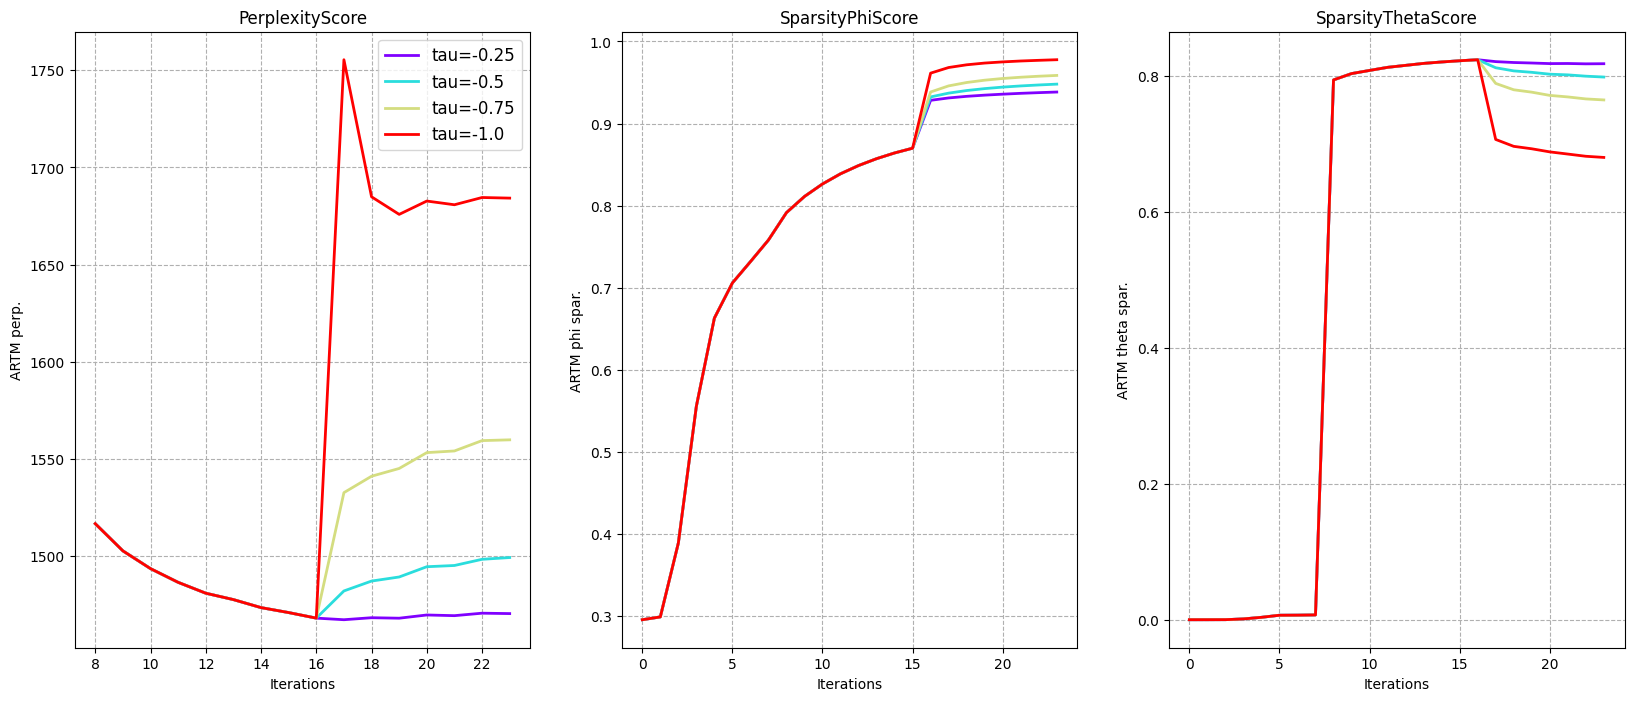

CPU times: user 4min 1s, sys: 3.59 s, total: 4min 4s
Wall time: 3min 39s


In [ ]:
%%time
BEST_THETA_SPARSE = -0.5
tau_vals = np.arange(1, 5) / 4
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_with3reg(artm.SmoothSparsePhiRegularizer, 'SmoothPhi', -tau_vals, colors, 8)

Приведем метрики при включения сглаживания $\Phi$

Best tau value: 0.25


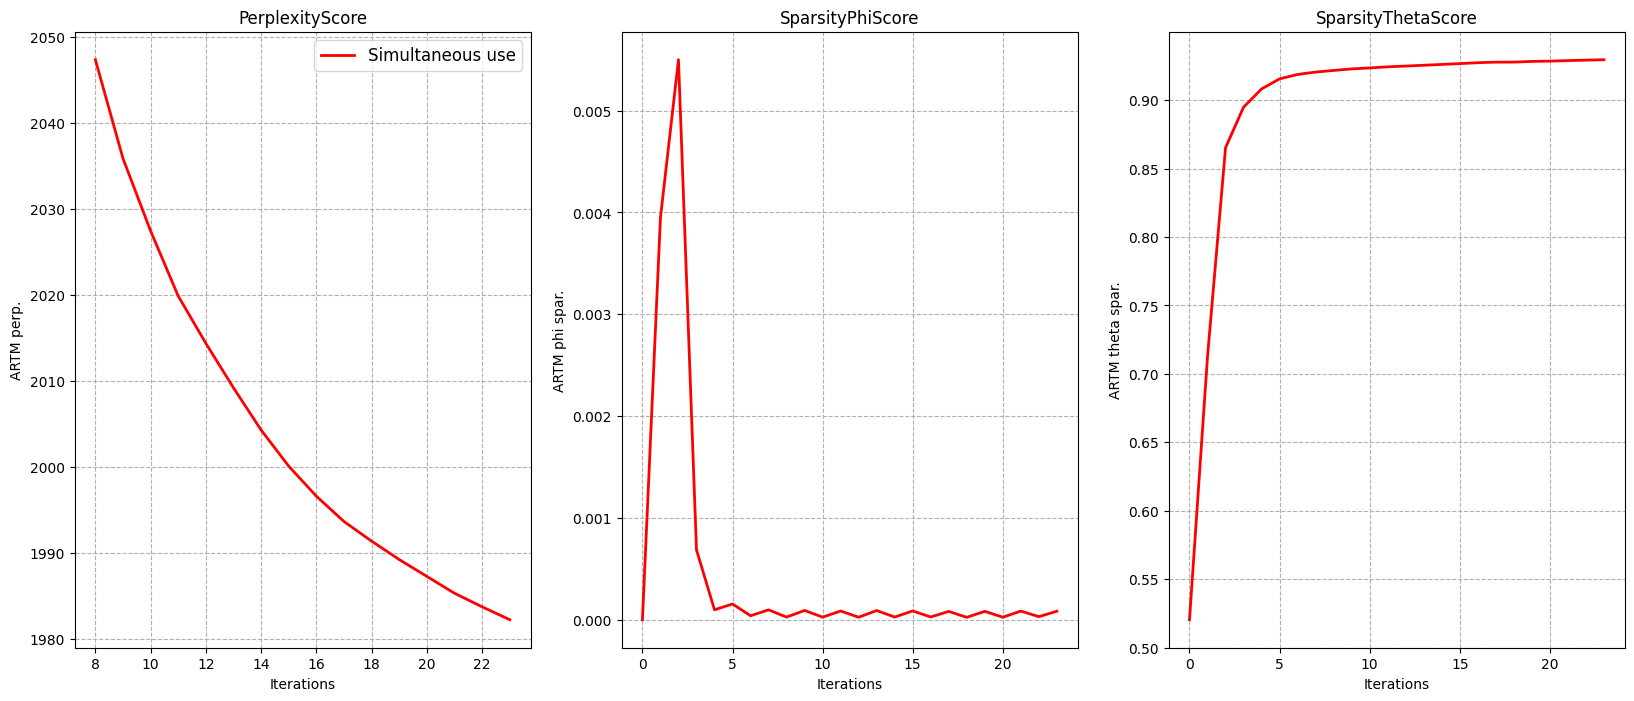

In [ ]:
diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))

model = create_artm_model()

model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=BEST_DECOR))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-1.5))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0.1))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=24)
diagram.add_scores(model, 'Simultaneous use', 'r', 8)

best_tau = diagram.best_tau(tau_vals)
print("Best tau value: {}".format(best_tau))

diagram.show()

In [ ]:
def test_with3reg_v2(regularizer, name, tau_vals, colors, epoch=8):
    diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))


    for (tau, c) in tqdm(zip(tau_vals, colors), total=len(tau_vals)):
        model = create_artm_model()

        model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=BEST_DECOR))
        model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0))
        model.regularizers.add(regularizer(name=name, tau=0))
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

        model.regularizers['SparseTheta'].tau = BEST_THETA_SPARSE
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

        model.regularizers['DecorPhi'].tau = 0
        model.regularizers[name].tau = tau
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)
        diagram.add_scores(model, f"tau={tau}", c, 8)

    best_tau = diagram.best_tau(tau_vals)
    print("Best tau value: {}".format(best_tau))

    diagram.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Best tau value: 0.125


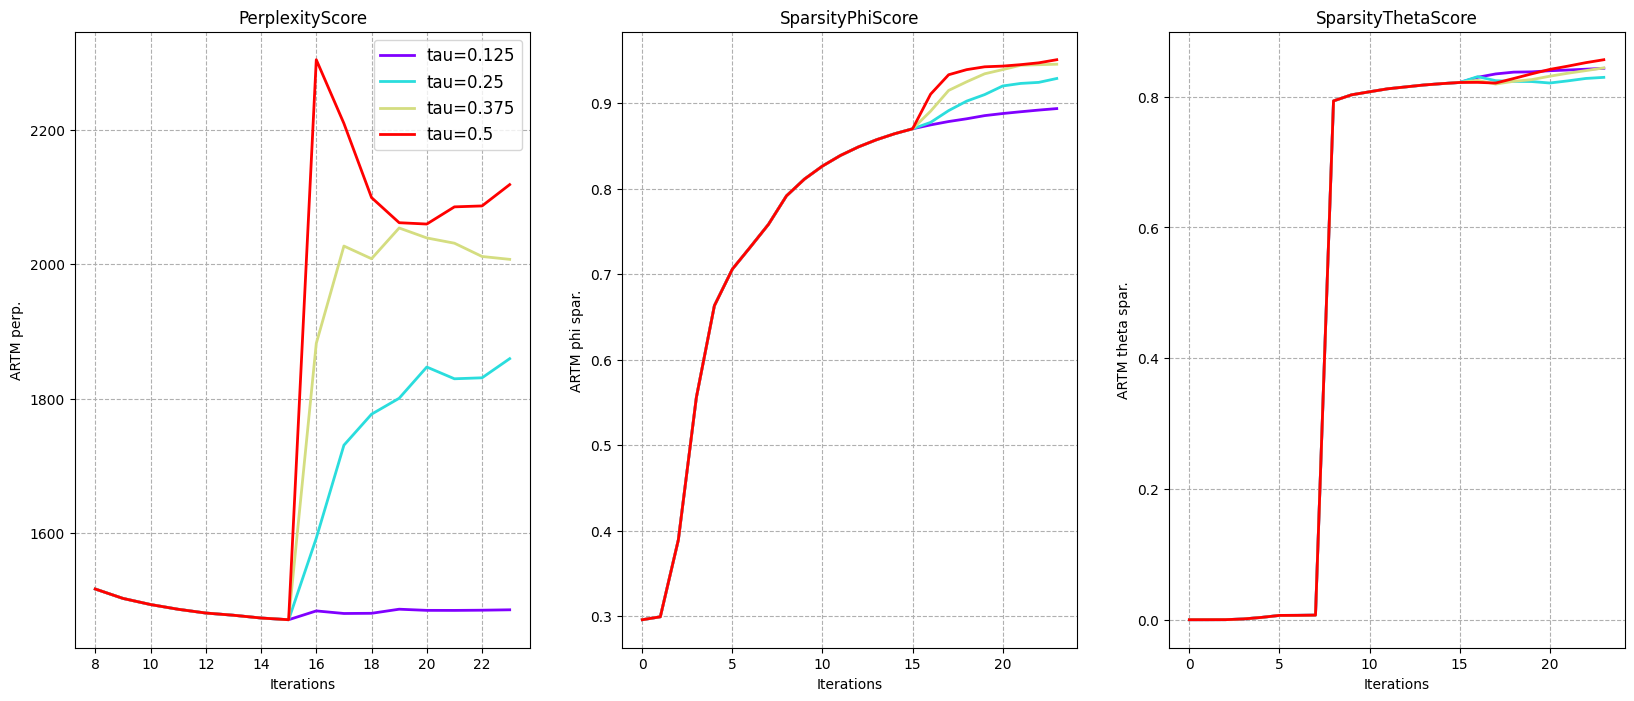

CPU times: user 3min 56s, sys: 4.26 s, total: 4min
Wall time: 3min 19s


In [ ]:
%%time
BEST_THETA_SPARSE = -0.5
tau_vals = np.arange(1, 5) / 8
colors = plt.cm.rainbow(np.linspace(0, 1, tau_vals.shape[0]))

test_with3reg_v2(artm.TopicSelectionThetaRegularizer, 'TopicSelector', tau_vals, colors, 8)

## 5. Сравнение метрик для baseline модели и для построенной последовательности регуляризаторов

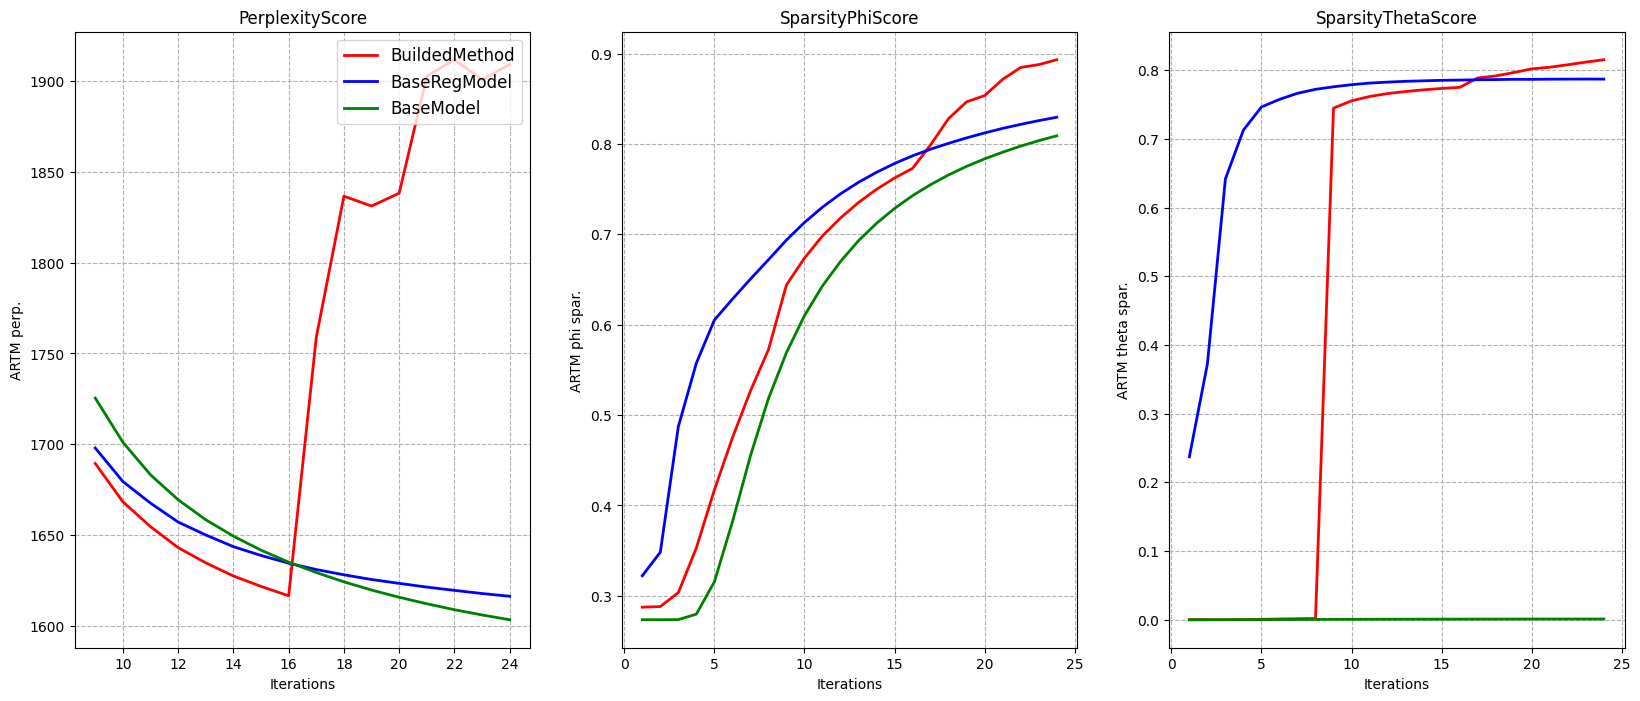

In [ ]:
epoch = 8
diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))

model = create_artm_model()

model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=2e5))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0))
model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelector', tau=0))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

model.regularizers['SparseTheta'].tau = -0.5
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

model.regularizers['DecorPhi'].tau = 0
model.regularizers['TopicSelector'].tau = 0.25
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)
diagram.add_scores(model, f"BuildedMethod", "r", 8)


model = create_artm_model()

model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=2e5))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch * 3)
diagram.add_scores(model, f"BaseRegModel", "b", 8)


model = create_artm_model()

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch * 3)
diagram.add_scores(model, f"BaseModel", "g", 8)

diagram.show()

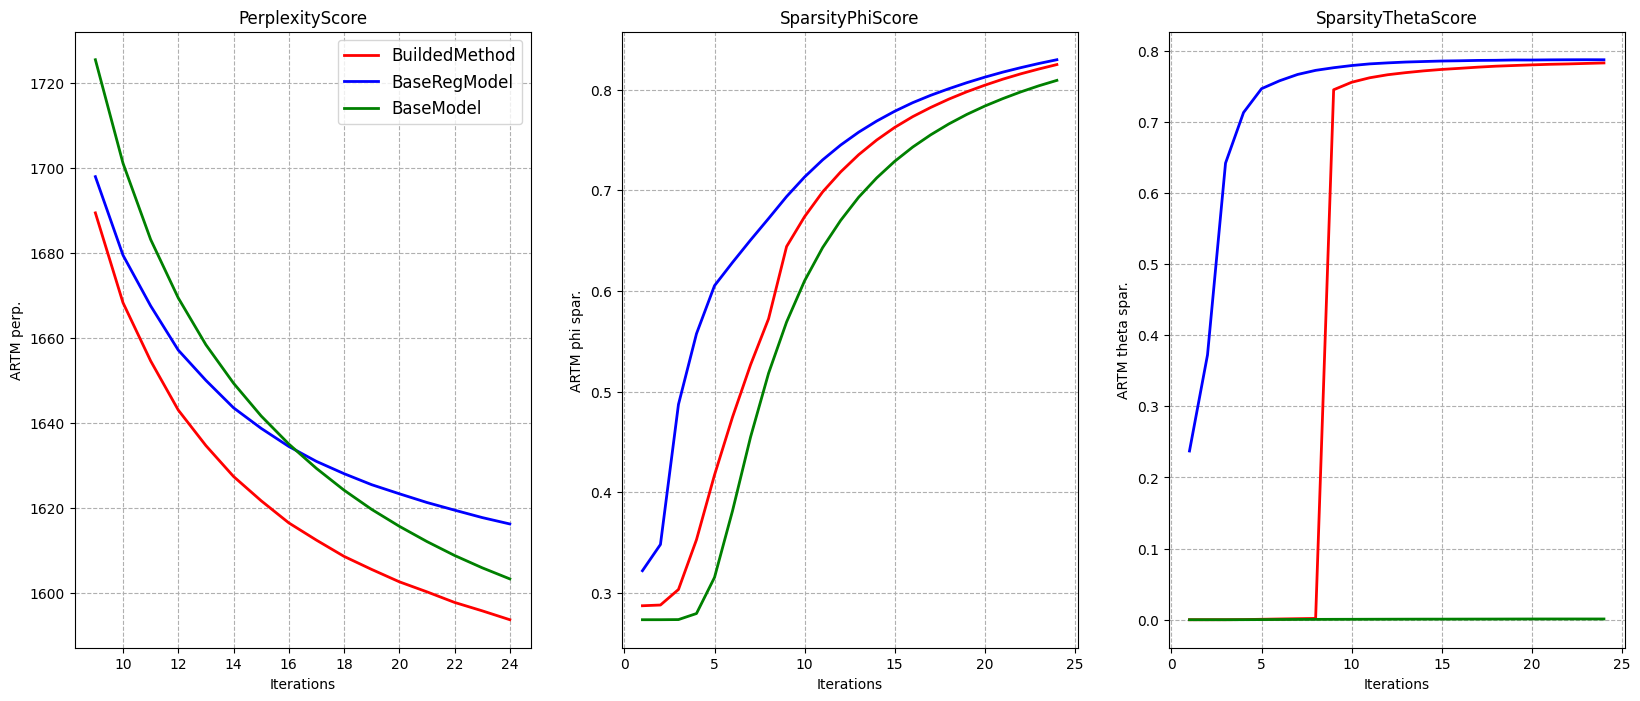

In [ ]:
epoch = 8
diagram = Diagram(nrows=1 , ncols=3, figsize=(20, 8))

model = create_artm_model()

model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=2e5))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch)

model.regularizers['SparseTheta'].tau = -0.5
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=2 * epoch)
diagram.add_scores(model, f"BuildedMethod", "r", 8)


model = create_artm_model()

model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorPhi', tau=2e5))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch * 3)
diagram.add_scores(model, f"BaseRegModel", "b", 8)


model = create_artm_model()

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=epoch * 3)
diagram.add_scores(model, f"BaseModel", "g", 8)

diagram.show()